## Fine-Tuning

The fine-tuning notebook is nearly identical in structure to the pre-training one. Here, the data used for training the encoder-decoder is the specialized fashion data, FashionGen. The pre-trained model is loaded from the checkpoint folder and then trained on the new dataset.

In [1]:
import os
from google.colab import drive
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel, EarlyStoppingCallback
from transformers import AutoImageProcessor, AutoTokenizer


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/FashionGen')

Mounted at /content/drive


The parameters are the same except max length of generated caption, which is changed from 32 to 128 to better fit the caption lengths in the FashionGen dataset. Also, to make longer captions possible, the exponential length penalty is lowered from 2.5 to 1.5. The learning rate is also reduced from $5 \cdot 10^{-5}$ to $5 \cdot 10^{-6}$ since the model weights need less change.

In [3]:
os.environ["WANDB_DISABLED"] = "true"

class config :
    TRAIN_BATCH_SIZE = 4
    VAL_BATCH_SIZE = 4
    LABEL_MASK = -100
    LR = 5e-6
    MAX_LEN = 128
    WEIGHT_DECAY = 0.01
    NUM_BEAMS = 5
    NO_REPEAT_NGRAM_SIZE = 3
    LENGTH_PENALTY = 1.5
    EPOCHS = 10
    SAVE_STEPS = 1000
    EVAL_STEPS = 500
    WARMUP_STEPS = 500
    PATIENCE = 5
    GRAD_ACC_STEPS = 4
    GRADIENT_CHECKPOINTING = True
    MIXED_PRECISION_TRAINING = True
    SAVE_TOTAL_LIMIT = 5

In [4]:
model_name_or_path = '../ViT_GPT2_RESULTS/checkpoint-9000'
model = VisionEncoderDecoderModel.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
encoder_model = "google/vit-base-patch16-224"
feature_extractor = AutoImageProcessor.from_pretrained(encoder_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, feature_extractor, tokenizer, device='cpu'):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.device = device
        self.loaded_images = {}
        self.images, self.captions = self.preload_data()

    def preload_data(self):
        images = []
        captions = []

        for idx in range(len(self.dataframe)):
            image_file = self.dataframe.iloc[idx]['image_file_name']
            caption_txt = self.dataframe.iloc[idx]['description']

            if image_file in self.loaded_images:
                img_tensor = self.loaded_images[image_file]
            else:
                image_path = os.path.join(self.image_dir, image_file)
                image = Image.open(image_path).convert("RGB")
                img_tensor = self.feature_extractor(images=image, \
                            return_tensors="pt").pixel_values.squeeze()
                self.loaded_images[image_file] = img_tensor

            caption = self.tokenizer(caption_txt, return_tensors="pt", \
                      padding='max_length', max_length=config.MAX_LEN, \
                      truncation=True)
            caption.input_ids[caption.input_ids == \
              self.tokenizer.pad_token_id] = config.LABEL_MASK
            caption_tensor = caption.input_ids.squeeze()

            images.append(img_tensor)
            captions.append(caption_tensor)

        return images, captions

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_tensor = self.images[idx]
        caption_tensor = self.captions[idx]

        return {"pixel_values": img_tensor, "labels": caption_tensor}

In [6]:
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

test_df.head()

,image_file_name,name,category,pose,product_ID,description
0,image_test_0.png,Blue Faded Elshar Jogg Jacket,JACKETS & COATS,1,86605,Denim-like jogg jacket in blue. Fading and whi...
1,image_test_1.png,Blue Faded Elshar Jogg Jacket,JACKETS & COATS,2,86605,Denim-like jogg jacket in blue. Fading and whi...
2,image_test_2.png,Blue Faded Elshar Jogg Jacket,JACKETS & COATS,3,86605,Denim-like jogg jacket in blue. Fading and whi...
3,image_test_3.png,Blue Faded Elshar Jogg Jacket,JACKETS & COATS,4,86605,Denim-like jogg jacket in blue. Fading and whi...
4,image_test_4.png,Light Grey Distressed Slim Jeans,JEANS,1,86773,Slim-fit jeans in light grey. Distressing and ...


In [7]:
train_dataset = CustomDataset(train_df, \
                './fashiongen_train_images', \
                feature_extractor, tokenizer)
val_dataset = CustomDataset(val_df, \
                './fashiongen_val_images', \
                feature_extractor, tokenizer)
test_dataset = CustomDataset(test_df, \
                './fashiongen_test_images', \
                feature_extractor, tokenizer)

In [8]:
def custom_data_collator(features):
    pixel_values = torch.stack([f["pixel_values"] for f in features])
    labels = torch.stack([f["labels"] for f in features])

    pixel_values = pixel_values.to(device)
    labels = labels.to(device)

    return {"pixel_values": pixel_values, "labels": labels}

In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./ViT_GPT2_FashionGen_RESULTS',
    logging_dir='./ViT_GPT2_FashionGen_LOGS',
    dataloader_pin_memory=False,
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    learning_rate=config.LR,
    weight_decay=config.WEIGHT_DECAY,
    predict_with_generate=True,
    do_train=True,
    do_eval=True,
    fp16=config.MIXED_PRECISION_TRAINING,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_steps=config.EVAL_STEPS,
    eval_steps=config.EVAL_STEPS,
    save_steps=config.SAVE_STEPS,
    warmup_steps=config.WARMUP_STEPS,
    num_train_epochs=config.EPOCHS,
    gradient_accumulation_steps=config.GRAD_ACC_STEPS,
    gradient_checkpointing=True,
    save_total_limit=config.SAVE_TOTAL_LIMIT,
    load_best_model_at_end=True,
    optim='adamw_hf'
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=custom_data_collator,
    callbacks=[EarlyStoppingCallback(\
        early_stopping_patience=config.PATIENCE)]
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Note that because there is early stopping enabled, training terminates after 9/10 epochs. This happens because validation loss doesn't improve for the 5 preceding validation evaluations.

In [10]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_

Step,Training Loss,Validation Loss
500,3.284800,1.768877
1000,1.668500,1.543204
1500,1.367700,1.498749
2000,1.174300,1.488227
2500,1.029400,1.505050
3000,0.916800,1.513444
3500,0.829800,1.530401
4000,0.767200,1.538791
4500,0.725200,1.548438


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 32, 'early_stopping': True, 'num_beams': 5, 'length_penalty': 2.5, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

TrainOutput(global_step=4500, training_loss=1.307080539279514, metrics={'train_runtime': 9851.1716, 'train_samples_per_second': 8.121, 'train_steps_per_second': 0.508, 'total_flos': 6.710704735046861e+19, 'train_loss': 1.307080539279514, 'epoch': 9.0})

In [5]:
model_name_or_path = './ViT_GPT2_FashionGen_RESULTS/checkpoint-2000'
model = VisionEncoderDecoderModel.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
encoder_model = "google/vit-base-patch16-224"
feature_extractor = AutoImageProcessor.from_pretrained(encoder_model)

model = model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

To evaluate model performance, consider 10 randomly selected train images. Note that the model trained on these images so captions are expected to be of higher quality.

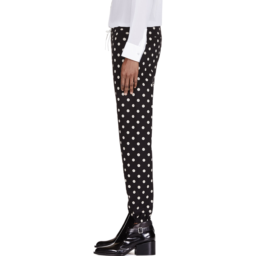

Actual Caption:  Tailored shorts in black. Four-pocket styling. Fully lined. Tonal stitching. Zip-closure.
Generated Caption:  Relaxed-fit pleated trousers in black. Four-pocket styling. Tonal stitching. Zip fly. Buttoned cinch belts at side waist


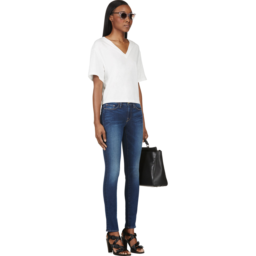

Actual Caption:  Circle skirt in black. Wrinkle effect throughout. Concealed zip closure at side. Bonded textile backing at interior. Tonal stitching.
Generated Caption:  Slim-fit jeans in blue. Fading, distressing, and paint spattering throughout. Five-pocket styling. Logo patch at back waistband


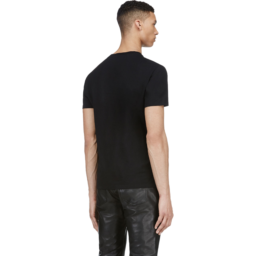

Actual Caption:  Long sleeve quilted bomber jacket in dark teal. Contrasting ribbed stand collar and sleeve cuffs in grey. Concealed zip closure at front. Zippered welt pockets at front. Fully lined. Tonal stitching.
Generated Caption:  Short sleeve cotton piqu&eacute polo in black. Ribbed spread collar and sleeve cuffs. Two-button placket. Embro


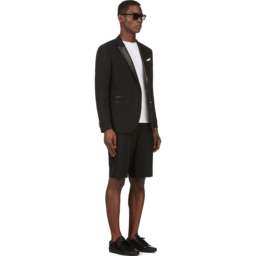

Actual Caption:  Ribbed cotton lounge shorts in black. Ribbed trim throughout. Drawstring waist with closure at interior. Top-stitched welt pockets at front. Contoured hem. Signature tricolor hang loop at waistband. Patch pocket at left seat with contrast mother-of-pearl button closure. Tonal stitching.
Generated Caption:  Long sleeve blazer in black. Notched lapel collar. Padded shoulders. Breast pocket. Single-button closure and flap pockets at front. V


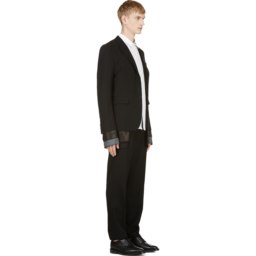

Actual Caption:  Supple buffed leather trousers in black. Five-pocket styling. Panel seams at knees. Tonal textile backing. Zip-fly.
Generated Caption:  Long sleeve shirt in white. Spread collar. Button closure at front. Breast pocket. Single-button barrel cuffs. Curved hem. Tonal stitching


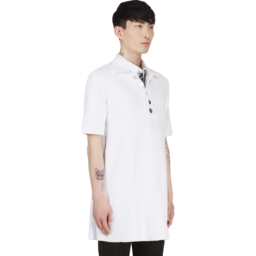

Actual Caption:  Silk blend sarouel lounge shorts in slate grey. Elasticized waistband in tonal cotton with contrasting beige drawstring closure. Side pockets with concealed zip closures. Sarouel paneling at upper leg. Paneled, notched gussets at side hem. Angled welt pockets at seat with concealed zip closures. Full lined. Tonal stitching.
Generated Caption:  Long sleeve shirt in white. Spread collar. Button closure at front. Breast pocket. Single-button barrel cuffs. Curved hem. Tonal stitching


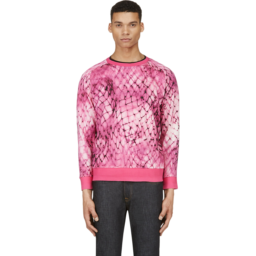

Actual Caption:  Long sleeve wool sweater in navy. Anchor pattern embroidered in red throughout. Ribbed knit crewneck collar, sleeve cuffs, and hem. Signature tri-color tab at back collar. Two-button placket at sleeve cuffs and side seams. Tonal stitching.
Generated Caption:  Long sleeve knit sweater in pink. Ribbed crewneck collar, sleeve cuffs, and hem. Tonal stitching. <br><br>


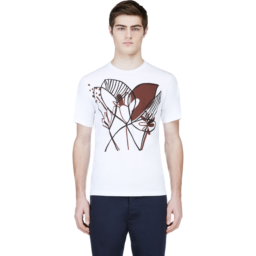

Actual Caption:  A-line mesh skirt in tones of blue, yellow, and pink. Mottled tie-dye effect throughout. Zip closure at back. Gathered at waistband. Fully lined. Tonal stitching.
Generated Caption:  Short sleeve t-shirt in white. Crewneck collar. Graphic print at front in black. Tonal stitching. <br><br>Part


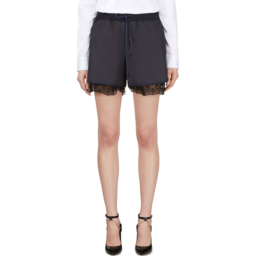

Actual Caption:  High-waisted slim-fit jeans in black. Five-pocket styling. Tonal leather logo patch at back waistband. Silver-tone metal logo letters at back pocket. Contrasting bonded rectangular graphics in white at leg. Tonal stitching. Zip-fly.
Generated Caption:  Relaxed-fit pleated shorts in navy blue. Four-pocket styling. Tonal stitching. Zip fly. Buttoned cinch belts at side


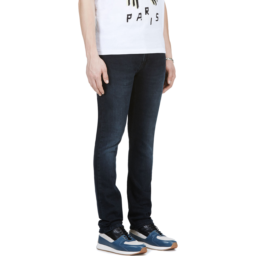

Actual Caption:  Long sleeve open-knit cotton-paper blend cardigan in ecru. Stand collar. Off-center button closure at front. Three-button placket detail at asymmetric hem. Tonal stitching.
Generated Caption:  Slim-fit jeans in deep blue. Fading, distressing, and paint spattering throughout. Five-pocket styling. Logo patch at back waist


In [10]:
train_df = pd.read_csv('train_data.csv')
train_samples = train_df.sample(10)
train_images = train_samples['image_file_name'].values
train_captions = train_samples['description'].values
img_dir = './fashiongen_train_images'

for idx, image_file in enumerate(train_images):
    image_path = os.path.join(img_dir, image_file)
    img =  Image.open(image_path).convert("RGB")
    display(img)
    print("Actual Caption: ", test_captions[idx])
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.squeeze().to("cuda")
    pixel_values = pixel_values.to(device).unsqueeze(0)
    model_output = model.generate(pixel_values)
    generated_caption = tokenizer.decode(model_output[0], skip_special_tokens=True)
    print("Generated Caption: ", generated_caption)

To evaluate the model's generalizability, we examine captions on 10 randomly selected images from the test data.

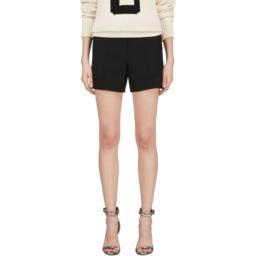

Actual Caption:  Tailored shorts in black. Four-pocket styling. Fully lined. Tonal stitching. Zip-closure.
Generated Caption:  Relaxed-fit pleated shorts in beige. Four-pocket styling. Tonal stitching. Zip fly. Buttoned cinch belts at side


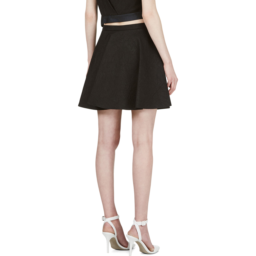

Actual Caption:  Circle skirt in black. Wrinkle effect throughout. Concealed zip closure at side. Bonded textile backing at interior. Tonal stitching.
Generated Caption:  Relaxed-fit pleated shorts in black. Four-pocket styling. Tonal stitching. Zip fly. Buttoned cinch belts at side waist


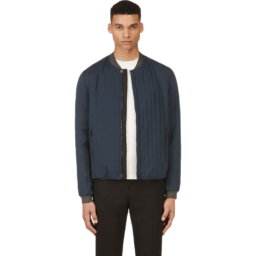

Actual Caption:  Long sleeve quilted bomber jacket in dark teal. Contrasting ribbed stand collar and sleeve cuffs in grey. Concealed zip closure at front. Zippered welt pockets at front. Fully lined. Tonal stitching.
Generated Caption:  Long sleeve hoodie in navy blue. Drawstrings at hood. Two-way zip closure at front. Ribbed knit sleeve cuffs and hem. Logo


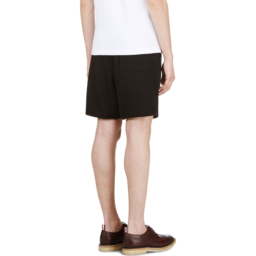

Actual Caption:  Ribbed cotton lounge shorts in black. Ribbed trim throughout. Drawstring waist with closure at interior. Top-stitched welt pockets at front. Contoured hem. Signature tricolor hang loop at waistband. Patch pocket at left seat with contrast mother-of-pearl button closure. Tonal stitching.
Generated Caption:  Relaxed-fit shorts in black. Drawstring at interior elasticised waistband. Four-pocket styling. Tonal stitching. Zip fly. Ton


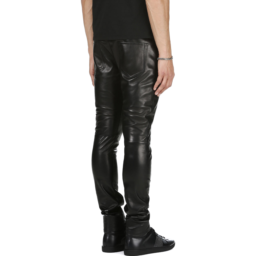

Actual Caption:  Supple buffed leather trousers in black. Five-pocket styling. Panel seams at knees. Tonal textile backing. Zip-fly.
Generated Caption:  Slim-fit buffed lambskin trousers in black. Four-pocket styling. Zippered ankle cuffs. Tonal stitching. Zip fly


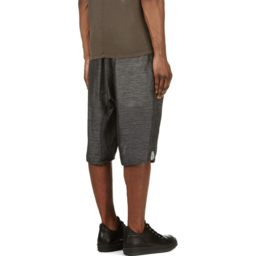

Actual Caption:  Silk blend sarouel lounge shorts in slate grey. Elasticized waistband in tonal cotton with contrasting beige drawstring closure. Side pockets with concealed zip closures. Sarouel paneling at upper leg. Paneled, notched gussets at side hem. Angled welt pockets at seat with concealed zip closures. Full lined. Tonal stitching.
Generated Caption:  Relaxed-fit sarouel-style shorts in grey. Elasticized waistband with drawstring closure at interior. Four-pocket styling. Ton


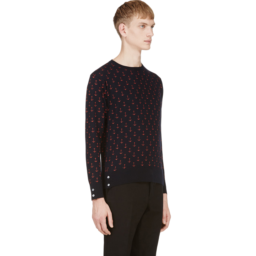

Actual Caption:  Long sleeve wool sweater in navy. Anchor pattern embroidered in red throughout. Ribbed knit crewneck collar, sleeve cuffs, and hem. Signature tri-color tab at back collar. Two-button placket at sleeve cuffs and side seams. Tonal stitching.
Generated Caption:  Long sleeve knit sweater in navy. Ribbed crewneck collar, sleeve cuffs, and hem. Tonal stitching. <br><br>


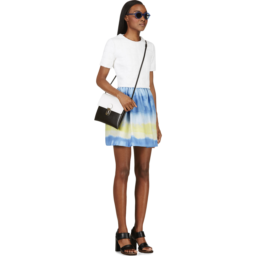

Actual Caption:  A-line mesh skirt in tones of blue, yellow, and pink. Mottled tie-dye effect throughout. Zip closure at back. Gathered at waistband. Fully lined. Tonal stitching.
Generated Caption:  Short sleeve t-shirt in white. Crewneck collar. Multicolor photographic print at front. Tonal stitching. <br><br>


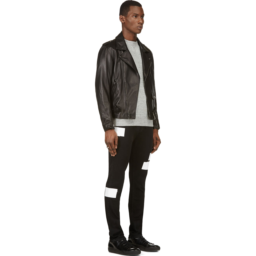

Actual Caption:  High-waisted slim-fit jeans in black. Five-pocket styling. Tonal leather logo patch at back waistband. Silver-tone metal logo letters at back pocket. Contrasting bonded rectangular graphics in white at leg. Tonal stitching. Zip-fly.
Generated Caption:  Long sleeve buffed lambskin biker jacket in black. Band collar with snap-stud closure. Zip closure at front. Zippered welt


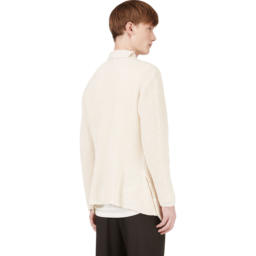

Actual Caption:  Long sleeve open-knit cotton-paper blend cardigan in ecru. Stand collar. Off-center button closure at front. Three-button placket detail at asymmetric hem. Tonal stitching.
Generated Caption:  Long sleeve sweatshirt in heather grey. Ribbed crewneck collar, cuffs, and hem. Raglan sleeves. Tonal stitching.


In [7]:
test_df = pd.read_csv('test_data.csv')
test_samples = test_df.sample(10)
test_images = test_samples['image_file_name'].values
test_captions = test_samples['description'].values
img_dir = './fashiongen_test_images'

for idx, image_file in enumerate(test_images):
    image_path = os.path.join(img_dir, image_file)
    img =  Image.open(image_path).convert("RGB")
    display(img)
    print("Actual Caption: ", test_captions[idx])
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.squeeze().to("cuda")
    pixel_values = pixel_values.to(device).unsqueeze(0)
    model_output = model.generate(pixel_values)
    generated_caption = tokenizer.decode(model_output[0], skip_special_tokens=True)
    print("Generated Caption: ", generated_caption)